# 날씨에 민감한 상품군 파악

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np
pd.set_option("max_rows", 500)
pd.set_option("max_columns", 500)
pd.set_option('float_format', '{:f}'.format)

import dataload

import os 
import datetime
from tqdm import tqdm 
from functools import reduce

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

import scipy.stats as stats

In [11]:
weather = pd.read_csv('weather_final2.csv', encoding='cp949')
weatherindex = pd.read_csv('data_with_weather.csv', encoding='cp949')
search = pd.read_csv('trend_with_weather.csv', encoding='cp949')

weather.shape, weatherindex.shape, search.shape

((11680, 29), (2056899, 18), (2568668, 12))

In [13]:
weather = weather.drop(['연', '월', '일', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절', '폭염여부', '강수여부', 'year', 'month'], axis=1)
weather.shape

(11680, 16)

In [15]:
weather.shape[0] == weather.날짜.nunique() * weather.지역.nunique()

True

In [28]:
weather = weather.rename(columns = {'날짜':'date'})

In [29]:
weather.head()

,date,지점번호,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,지역,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수
0,2018-01-01,105,1.300000,5.700000,-2.100000,0.000000,0.000000,3.700000,강릉,20.066667,13.400000,25.400000,57.900000,1023.000000,7.502056,-39.701524
1,2018-01-01,112,-0.300000,2.700000,-2.700000,0.000000,0.000000,1.600000,인천,37.518681,18.641758,67.200000,53.800000,1020.300000,9.992379,-42.924922
2,2018-01-01,119,-1.700000,4.700000,-6.900000,0.000000,0.000000,1.000000,수원,42.782895,21.375000,84.700000,52.700000,1025.100000,10.136402,-45.791893
3,2018-01-01,136,-1.000000,4.700000,-6.500000,0.000000,0.000000,2.200000,안동,39.750000,28.583333,56.400000,58.300000,1010.600000,8.356692,-44.375704
4,2018-01-01,152,2.100000,6.200000,-0.400000,0.000000,0.000000,3.300000,울산,38.548193,15.433735,42.800000,58.300000,1017.100000,8.861429,-38.064334


In [17]:
buy_full = dataload.load_buy()
print(buy_full.shape)
buy_full.head()

(2056899, 6)


,date,sex,age,big_cat,sm_cat,qty
0,20180101,F,20,식품,가공란,37
1,20180101,F,30,식품,가공란,16
2,20180101,F,40,식품,가공란,9
3,20180101,F,50,식품,가공란,3
4,20180101,M,20,식품,가공란,13


In [22]:
tqdm.pandas()
weather["날짜"] = weather["날짜"].progress_apply(lambda x : pd.to_datetime(str(x), format="%Y-%m-%d"))
buy_full["date"] = buy_full["date"].progress_apply(lambda x : pd.to_datetime(str(x), format="%Y-%m-%d"))

100%|██████████| 2056899/2056899 [02:30<00:00, 13665.68it/s]


In [24]:
buy = buy_full.groupby(['date', 'sm_cat']).sum('qty').reset_index()[["sm_cat", "date", "qty"]]
buy.shape

(267707, 3)

## 1. Correlation 기준 체크 
* 지역 설정 필요! 

In [109]:
def weather_correlation(product, loc) : 
    df1 = weather[weather.지역 == loc].reset_index(drop=True)
    df2 = buy[buy.sm_cat == product]
    df = df1.merge(df2, on="date", how='left')
    df['sm_cat'] = df['sm_cat'].fillna(product) ; df['qty'] = df['qty'].fillna(0)
    co = np.abs(df.corr(method='spearman')["qty"][1:-1])
    return sum(co)

In [110]:
result = pd.DataFrame({
    'category' : buy.sm_cat.unique()
})

result["correlation"] = result["category"].progress_apply(lambda x : weather_correlation(x, '서울'))

100%|██████████| 383/383 [00:07<00:00, 49.64it/s]


In [111]:
result.sort_values('correlation', ascending=False).head(30)

,category,correlation
287,초음파식 가습기,6.373866
156,복합식 가습기,6.293211
7,감귤/한라봉/오렌지,6.200598
48,굴 생물,6.134065
238,에어워셔,5.878635
237,업소용 선풍기,5.736088
330,해초류,5.639178
332,핸드크림,5.630654
161,뷰티 타투,5.622354
363,히터,5.610631


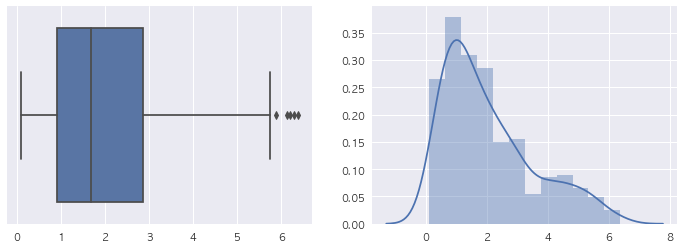

In [112]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4) 

sns.boxplot(result[["correlation"]], ax=ax1)
sns.distplot(result[["correlation"]], ax=ax2)

In [99]:
result[["correlation"]].describe()

,correlation
count,383.000000
mean,1.648621
std,1.195916
min,0.110424
25%,0.722042
50%,1.272138
75%,2.260680
max,5.643818


In [113]:
buy_category = buy_full[["big_cat", 'sm_cat']].drop_duplicates().reset_index()
buy_category = buy_category.merge(result, left_on='sm_cat', right_on="category", how='left')
buy_category.shape

(383, 5)

In [114]:
buy_category[buy_category["correlation"] > 1.5].shape

(201, 5)

In [115]:
buy_category[buy_category["correlation"] > 1.5].big_cat.value_counts()

식품       94
뷰티       72
냉난방가전    35
Name: big_cat, dtype: int64

## 2. 날씨 데이터 상세하게 체크하기 
* 중복되는 의미 제거하고, 의미가 크지 않을 것 같은 변수 제거하기 

In [116]:
def weather_correlation2(product, loc) : 
    df1 = weather[weather.지역 == loc].reset_index(drop=True)
    df2 = buy[buy.sm_cat == product]
    df = df1.merge(df2, on="date", how='left')
    df['sm_cat'] = df['sm_cat'].fillna(product) ; df['qty'] = df['qty'].fillna(0)
    co = dict(np.abs(df.corr(method='spearman')["qty"][1:-1]))
    co["category"] = product
    return co

In [117]:
weather_correlation2('여성향수', '서울')

{'평균기온': 0.04154031615280878,
 '최고기온': 0.04119352528694497,
 '최저기온': 0.041967186413414674,
 '일별강수량': 0.013859733083079685,
 '1시간최대강수량': 0.01367135399605151,
 '평균풍속': 0.01085003531200246,
 'PM10': 0.02985433992788291,
 'PM25': 0.023237828487208234,
 '1시간최대습도': 0.03905909212122805,
 '일조시간합': 0.00747209797925452,
 '최고현지기압': 0.03689823356119712,
 '체감온도': 0.0422336320996635,
 '열지수': 0.04153995351621837,
 'category': '여성향수'}

In [123]:
result2 = pd.DataFrame()

for cat in tqdm(buy.sm_cat.unique()) : 
    result2 = result2.append(pd.DataFrame(weather_correlation2(cat, '서울'), index=[0]), ignore_index=True)

100%|██████████| 383/383 [00:08<00:00, 46.03it/s]


In [124]:
result2.head()

,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,category
0,0.009877,0.021020,0.001328,0.005753,0.010935,0.072498,0.120930,0.124314,0.012046,0.037676,0.041550,0.002262,0.009829,가공란
1,0.694533,0.681181,0.694446,0.233596,0.234399,0.064768,0.237118,0.148534,0.296310,0.052795,0.751439,0.688523,0.694727,가열식 가습기
2,0.170540,0.171172,0.175308,0.000188,0.007253,0.139302,0.096851,0.076179,0.022130,0.030031,0.129089,0.180686,0.170363,가자미
3,0.178182,0.154441,0.189870,0.120279,0.126110,0.050932,0.149490,0.100031,0.120812,0.136970,0.111733,0.170383,0.178458,갈비/찜/바비큐용 돈육
4,0.014486,0.009800,0.012349,0.024601,0.030742,0.085889,0.079819,0.052615,0.018723,0.061375,0.012293,0.008348,0.014452,갈비용 우육


In [147]:
buy_category2 = buy_full[["big_cat", 'sm_cat']].drop_duplicates().reset_index(drop=True)
buy_category2 = buy_category2.merge(result2, left_on='sm_cat', right_on="category", how='left')
buy_category2 = buy_category2.drop('category', axis=1)
buy_category2.shape

(383, 15)

In [148]:
buy_category2.head()

,big_cat,sm_cat,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수
0,식품,가공란,0.009877,0.021020,0.001328,0.005753,0.010935,0.072498,0.120930,0.124314,0.012046,0.037676,0.041550,0.002262,0.009829
1,냉난방가전,가열식 가습기,0.694533,0.681181,0.694446,0.233596,0.234399,0.064768,0.237118,0.148534,0.296310,0.052795,0.751439,0.688523,0.694727
2,식품,가자미,0.170540,0.171172,0.175308,0.000188,0.007253,0.139302,0.096851,0.076179,0.022130,0.030031,0.129089,0.180686,0.170363
3,식품,갈비/찜/바비큐용 돈육,0.178182,0.154441,0.189870,0.120279,0.126110,0.050932,0.149490,0.100031,0.120812,0.136970,0.111733,0.170383,0.178458
4,식품,갈비용 우육,0.014486,0.009800,0.012349,0.024601,0.030742,0.085889,0.079819,0.052615,0.018723,0.061375,0.012293,0.008348,0.014452


In [155]:
buy_category2["correlation"] = buy_category2.loc[:,list(buy_category2.columns)[2:]].sum(axis=1)

In [156]:
buy_category2.head()

,big_cat,sm_cat,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,correlation
0,식품,가공란,0.009877,0.021020,0.001328,0.005753,0.010935,0.072498,0.120930,0.124314,0.012046,0.037676,0.041550,0.002262,0.009829,0.470018
1,냉난방가전,가열식 가습기,0.694533,0.681181,0.694446,0.233596,0.234399,0.064768,0.237118,0.148534,0.296310,0.052795,0.751439,0.688523,0.694727,5.472369
2,식품,가자미,0.170540,0.171172,0.175308,0.000188,0.007253,0.139302,0.096851,0.076179,0.022130,0.030031,0.129089,0.180686,0.170363,1.369090
3,식품,갈비/찜/바비큐용 돈육,0.178182,0.154441,0.189870,0.120279,0.126110,0.050932,0.149490,0.100031,0.120812,0.136970,0.111733,0.170383,0.178458,1.787689
4,식품,갈비용 우육,0.014486,0.009800,0.012349,0.024601,0.030742,0.085889,0.079819,0.052615,0.018723,0.061375,0.012293,0.008348,0.014452,0.425492


In [158]:
buy_category2.sort_values(['평균기온', 'PM10', '일별강수량', 'correlation'], ascending=False).head(30)

,big_cat,sm_cat,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,correlation
287,냉난방가전,초음파식 가습기,0.819175,0.802823,0.818688,0.249171,0.249580,0.057451,0.315716,0.206995,0.323280,0.062754,0.837361,0.811464,0.819407,6.373866
156,냉난방가전,복합식 가습기,0.799613,0.781798,0.801828,0.247738,0.246761,0.070702,0.335301,0.234304,0.319788,0.060826,0.801455,0.793238,0.799858,6.293211
7,식품,감귤/한라봉/오렌지,0.781819,0.772209,0.779825,0.220087,0.224351,0.143872,0.339007,0.240850,0.264361,0.117065,0.754324,0.780989,0.781839,6.200598
48,식품,굴 생물,0.778428,0.769005,0.775915,0.209510,0.202766,0.091692,0.335131,0.259586,0.262712,0.121048,0.776070,0.773794,0.778408,6.134065
363,냉난방가전,히터,0.743829,0.734978,0.735393,0.200600,0.201550,0.070072,0.215728,0.116304,0.257924,0.077392,0.775258,0.737711,0.743890,5.610631
237,냉난방가전,업소용 선풍기,0.742508,0.732373,0.734911,0.207005,0.203186,0.060012,0.289943,0.184661,0.274205,0.101560,0.726278,0.736737,0.742709,5.736088
370,냉난방가전,탁상/USB 선풍기,0.740497,0.735811,0.729797,0.177454,0.174490,0.031198,0.209376,0.113882,0.248366,0.116136,0.751549,0.731666,0.740567,5.500790
238,냉난방가전,에어워셔,0.735215,0.717777,0.734148,0.240862,0.242960,0.080973,0.346412,0.243839,0.296342,0.042640,0.730367,0.731731,0.735368,5.878635
332,뷰티,핸드크림,0.731759,0.721303,0.726084,0.193824,0.193430,0.101470,0.258004,0.161740,0.245471,0.090728,0.746622,0.728325,0.731893,5.630654
161,뷰티,뷰티 타투,0.722963,0.719358,0.714999,0.177168,0.183630,0.080317,0.294297,0.197834,0.263440,0.125605,0.701808,0.717897,0.723038,5.622354


In [159]:
buy_category2.describe()

,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,correlation
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,0.249870,0.247704,0.247735,0.065854,0.067302,0.080325,0.118320,0.091320,0.085571,0.054952,0.241891,0.248566,0.249866,2.049274
std,0.204447,0.202430,0.202235,0.055696,0.055755,0.053475,0.093951,0.073999,0.073784,0.041940,0.210621,0.202497,0.204481,1.484052
min,0.001421,0.002400,0.000224,0.000029,0.000392,0.000666,0.001224,0.000592,0.000319,0.000730,0.000838,0.000232,0.001286,0.094381
25%,0.086267,0.085879,0.088158,0.020545,0.023135,0.036780,0.042375,0.034944,0.023711,0.021595,0.072169,0.085195,0.086287,0.908728
50%,0.188603,0.183763,0.192829,0.049055,0.051351,0.072902,0.093782,0.072543,0.069420,0.045784,0.174906,0.192136,0.188549,1.679599
75%,0.366753,0.368448,0.364458,0.101640,0.102295,0.114823,0.179307,0.135879,0.124436,0.076340,0.356827,0.363546,0.366750,2.852804
max,0.819175,0.802823,0.818688,0.290211,0.287352,0.254873,0.556420,0.449979,0.343261,0.189992,0.837361,0.811464,0.819407,6.373866


In [161]:
print("* 기온 *")
print(buy_category2[buy_category2['평균기온']>0.35].shape)
buy_category2[buy_category2['평균기온']>0.35].big_cat.value_counts()

* 기온 *
(106, 16)


식품       47
뷰티       30
냉난방가전    29
Name: big_cat, dtype: int64